# Fine-Tuning and Quantization of MobileNetV3 for AI Deck

This notebook demonstrates the process of fine-tuning a pre-trained MobileNetV3Small model on a custom dataset and quantizing it for deployment on the AI Deck. The AI Deck is a powerful tool for running lightweight AI models on drones, and optimizing models for it involves careful consideration of size, accuracy, and compatibility.

The notebook is divided into the following sections:

1. **Data Preparation**: Loading and augmenting the dataset.
2. **Model Definition**: Setting up a MobileNetV3-based architecture.
3. **Training**: Fine-tuning the model for our custom dataset.
4. **Evaluation**: Assessing the model's performance.
5. **Model Conversion and Quantization**: Preparing the model for deployment on the AI Deck.
6. **Testing the Quantized Model**: Verifying the functionality of the quantized model.

## Prerequisites

Before running this notebook, ensure you have the following installed and configured:

1. **Python Environment**:
   - Python 3.8–3.11
   - A virtual environment or Conda environment is recommended to manage dependencies.

2. **Required Libraries**:
   - `TensorFlow >= 2.10`
   - `NumPy`
   - `Pandas`
   - `Matplotlib`
   - `Pillow`
   - `SciPy`
   - `Seaborn`

   You can install the required libraries with:
   ```bash
   pip install tensorflow numpy pandas matplotlib pillow scipy

3. **Dataset**:

   - A labeled dataset organized in the following structure:

    training_data/
      train/
        class1/
        class2/
        ...
      validation/
        class1/
        class2/
        ...

   - Ensure the dataset is prepared with appropriate augmentations for training.
   - For a quick start, you can use the provided example dataset: `training_data/training_data_christmas_packet.zip` Extract the archive to a folder before running the notebook.

4. **Hardware**:

   - A GPU-enabled machine is recommended for faster training.
    Ensure TensorFlow is configured to use your GPU if available.

5. **AI Deck Environment (for deployment)**:

   - Install the necessary tools and libraries to work with the AI Deck.

Refer to the official [AI Deck documentation](https://www.bitcraze.io/documentation/tutorials/getting-started-with-aideck/) documentation for setup instructions or README.

## Imports

In [1]:
import os
import argparse
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import zipfile

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input,
    Resizing,
    Conv2D,
    GlobalAveragePooling2D,
    Dropout,
    Dense
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

2025-01-13 11:45:38.858521: I tensorflow/core/platform/cpu_feature_guard.cc:181] Beginning TensorFlow 2.15, this package will be updated to install stock TensorFlow 2.15 alongside Intel's TensorFlow CPU extension plugin, which provides all the optimizations available in the package and more. If a compatible version of stock TensorFlow is present, only the extension will get installed. No changes to code or installation setup is needed as a result of this change.
More information on Intel's optimizations for TensorFlow, delivered as TensorFlow extension plugin can be viewed at https://github.com/intel/intel-extension-for-tensorflow.
2025-01-13 11:45:38.858541: I tensorflow/core/platform/cpu_feature_guard.cc:192] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Prepare the Dataset and Initialize Arguments
This section uses command-line style argument parsing adapted for the notebook environment. It initializes parameters and ensures the dataset is prepared.

In [2]:
# Emulate argparse in Jupyter
class Args:
    epochs = 40
    finetune_epochs = 20
    dataset_path = "training_data"
    batch_size = 16
    image_width = 324
    image_height = 244
    image_channels = 1
    print_plot = True

args = Args()

# Define paths
ROOT_PATH = f"{os.path.abspath(os.curdir)}"
DATASET_PATH = f"{ROOT_PATH}/{args.dataset_path}"

# Check and extract dataset if 'train' and 'validation' are missing
train_path = os.path.join(DATASET_PATH, "train")
val_path = os.path.join(DATASET_PATH, "validation")

if not os.path.exists(train_path) or not os.path.exists(val_path):
    zip_path = os.path.join(DATASET_PATH, "training_data_christmas_packet.zip")
    if not os.path.exists(zip_path):
        raise FileNotFoundError(
            f"The dataset zip file '{zip_path}' does not exist. "
            "Ensure the file is present in the dataset path."
        )

    print(f"Extracting dataset from {zip_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(DATASET_PATH)
    print("Dataset extracted successfully.")

    # Re-check for the train and validation directories
    if not os.path.exists(train_path) or not os.path.exists(val_path):
        raise FileNotFoundError(
            f"After extraction, 'train' or 'validation' directories were still not found in '{DATASET_PATH}'."
        )

print(f"Dataset prepared at: {DATASET_PATH}")

# Data augmentation for the training dataset
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255.0,  # Normalize pixel values to [0, 1]
    rotation_range=15,  # Randomly rotate images within ±15°
    shear_range=0.2,  # Apply random shearing transformations up to 20%
    zoom_range=0.2,  # Randomly zoom in/out up to ±20%
    width_shift_range=0.1,  # Horizontally shift images by up to 10%
    height_shift_range=0.1,  # Vertically shift images by up to 10%
    horizontal_flip=True,  # Allow horizontal flipping of images
    vertical_flip=False,  # Skip vertical flipping (not logical for this dataset)
    brightness_range=[0.5, 1.5]  # Randomly adjust brightness between 50% and 150%
)

# Data augmentation for the validation dataset
# Only rescaling is applied to ensure consistency in validation
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255.0  # Normalize pixel values to [0, 1]
)

if args.image_channels == 1:
    color_mode = "grayscale"
else:
    color_mode = "rgb"

# Load training and validation datasets
train_generator = train_datagen.flow_from_directory(
    f"{DATASET_PATH}/train",
    target_size=(args.image_width, args.image_height),
    batch_size=args.batch_size,
    class_mode="categorical",
    color_mode=color_mode
)

val_generator = val_datagen.flow_from_directory(
    f"{DATASET_PATH}/validation",
    target_size=(args.image_width, args.image_height),
    batch_size=args.batch_size,
    class_mode="categorical",
    color_mode=color_mode
)

# Save class labels to a text file
print("Class Indices:", train_generator.class_indices)
labels = "\n".join(sorted(train_generator.class_indices.keys()))
with open(f"{ROOT_PATH}/class_labels.txt", "w") as f:
    f.write(labels)


Dataset prepared at: /home/zboucek/mygit/cf/aideck-gap8-examples/examples/ai/classification/training_data
Found 1375 images belonging to 2 classes.
Found 450 images belonging to 2 classes.
Class Indices: {'background': 0, 'packet': 1}


## Model Building and Training

In this section, we will define the architecture of the neural network using MobileNetV3Small as the base model. The model will then be trained using the prepared dataset. The training will be conducted in two stages: initial training with frozen weights of the base model, and fine-tuning with unfrozen weights.


In [3]:
# Define the model architecture
base_model = MobileNetV3Small(
    input_shape=(244, 244, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # Freeze the base model for initial training

if args.image_channels == 1:
    print("Detected grayscale images, adding conversion layer.")
    input_layer = tf.keras.Sequential([
        tf.keras.Input(shape=(args.image_width, args.image_height, 1)),
        tf.keras.layers.Conv2D(filters=3, kernel_size=(1, 1), activation=None),
        tf.keras.layers.Resizing(244, 244, interpolation="bilinear")
    ])
else:
    print("Detected RGB images, resizing only.")
    input_layer = tf.keras.Sequential([
        tf.keras.Input(shape=(args.image_width, args.image_height, 3)),
        tf.keras.layers.Resizing(244, 244, interpolation="bilinear")
    ])

# Add custom layers on top of the base model
model = Sequential([
    input_layer,
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(units=len(train_generator.class_indices), activation="softmax")
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.build(input_shape=(None, args.image_width, args.image_height, args.image_channels))
model.summary()

2025-01-13 11:45:40.775996: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Detected grayscale images, adding conversion layer.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 244, 244, 3)       6         
                                                                 
 MobilenetV3small (Function  (None, 8, 8, 576)         939120    
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 576)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 2)                 1154      
                                                                 
To

In [4]:
# Early stopping to terminate training when validation loss stops improving
early_stopping = EarlyStopping(
    monitor='val_loss',          # Monitors validation loss
    patience=5,                  # Number of epochs without improvement before stopping
    verbose=1,                   # Print messages when stopping
    restore_best_weights=True    # Reverts to the best weights after stopping
)

# Learning rate scheduler to reduce learning rate when validation loss plateaus
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',          # Monitors validation loss
    factor=0.5,                  # Reduces the learning rate by a factor (e.g., halves it)
    patience=3,                  # Number of epochs without improvement before reducing learning rate
    verbose=1,                   # Print messages when reducing learning rate
    min_lr=1e-6                  # Minimum allowed learning rate
)

# Train the model
max_epochs = args.epochs
history = model.fit(
    train_generator,                            # Training data generator
    validation_data=val_generator,              # Validation data generator
    epochs=max_epochs,                          # Maximum number of epochs
    callbacks=[early_stopping, lr_scheduler]    # List of callbacks
)

Epoch 1/40
86/86 [==============================] - 54s 596ms/step - loss: 0.7066 - accuracy: 0.5193 - val_loss: 0.6876 - val_accuracy: 0.5533 - lr: 0.0010
Epoch 2/40
86/86 [==============================] - 52s 605ms/step - loss: 0.7105 - accuracy: 0.5135 - val_loss: 0.7256 - val_accuracy: 0.4467 - lr: 0.0010
Epoch 3/40
86/86 [==============================] - 52s 609ms/step - loss: 0.7050 - accuracy: 0.5251 - val_loss: 0.6892 - val_accuracy: 0.5533 - lr: 0.0010
Epoch 4/40
86/86 [==============================] - ETA: 0s - loss: 0.7137 - accuracy: 0.5076
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
86/86 [==============================] - 51s 593ms/step - loss: 0.7137 - accuracy: 0.5076 - val_loss: 0.6882 - val_accuracy: 0.5533 - lr: 0.0010
Epoch 5/40
86/86 [==============================] - 50s 587ms/step - loss: 0.6966 - accuracy: 0.5367 - val_loss: 0.6881 - val_accuracy: 0.5533 - lr: 5.0000e-04
Epoch 6/40
86/86 [==============================] - 50s 5

In [5]:

# Unfreeze the base model for fine-tuning
base_model.trainable = True
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Fine-tune the model
fine_tune_epochs = args.finetune_epochs
total_epochs = max_epochs + fine_tune_epochs
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    callbacks=[early_stopping, lr_scheduler]  # Include callbacks
)

Epoch 34/60
86/86 [==============================] - 497s 6s/step - loss: 0.3063 - accuracy: 0.8647 - val_loss: 0.6994 - val_accuracy: 0.5533 - lr: 1.0000e-04
Epoch 35/60
86/86 [==============================] - 477s 6s/step - loss: 0.0814 - accuracy: 0.9782 - val_loss: 0.7110 - val_accuracy: 0.4467 - lr: 1.0000e-04
Epoch 36/60
86/86 [==============================] - 476s 6s/step - loss: 0.0428 - accuracy: 0.9891 - val_loss: 0.8612 - val_accuracy: 0.4467 - lr: 1.0000e-04
Epoch 37/60
86/86 [==============================] - ETA: 0s - loss: 0.0328 - accuracy: 0.9891
Epoch 37: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
86/86 [==============================] - 477s 6s/step - loss: 0.0328 - accuracy: 0.9891 - val_loss: 1.0247 - val_accuracy: 0.4467 - lr: 1.0000e-04
Epoch 38/60
86/86 [==============================] - 477s 6s/step - loss: 0.0156 - accuracy: 0.9971 - val_loss: 1.2166 - val_accuracy: 0.4467 - lr: 5.0000e-05
Epoch 39/60
86/86 [==========================

## Saving the Trained Model and Evaluating Its Performance

Once the model has been trained, we save it for later use and evaluate its performance. The evaluation metrics include accuracy on both the training and validation datasets. This step ensures that the model is saved in a reusable format for conversion or deployment.

In [6]:
# Define paths to save the model
model_save_dir = os.path.join(os.getcwd(), "model")
os.makedirs(model_save_dir, exist_ok=True)
model_save_path = os.path.join(model_save_dir, "model.keras")

# Save the model in .keras format
model.save(model_save_path)
print(f"Model saved to: {model_save_path}")

# Evaluate the model on the validation dataset
val_loss, val_accuracy = model.evaluate(val_generator, verbose=1)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4%}")

Model saved to: /home/zboucek/mygit/cf/aideck-gap8-examples/examples/ai/classification/model/model.keras
29/29 [==============================] - 3s 104ms/step - loss: 0.6994 - accuracy: 0.5533
Validation Loss: 0.6994
Validation Accuracy: 55.3333%


## Training Progress Visualization

In this section, we visualize the training progress using loss and accuracy metrics for both training and validation data. These plots help us understand whether the model is improving over time and if there are signs of overfitting or underfitting.

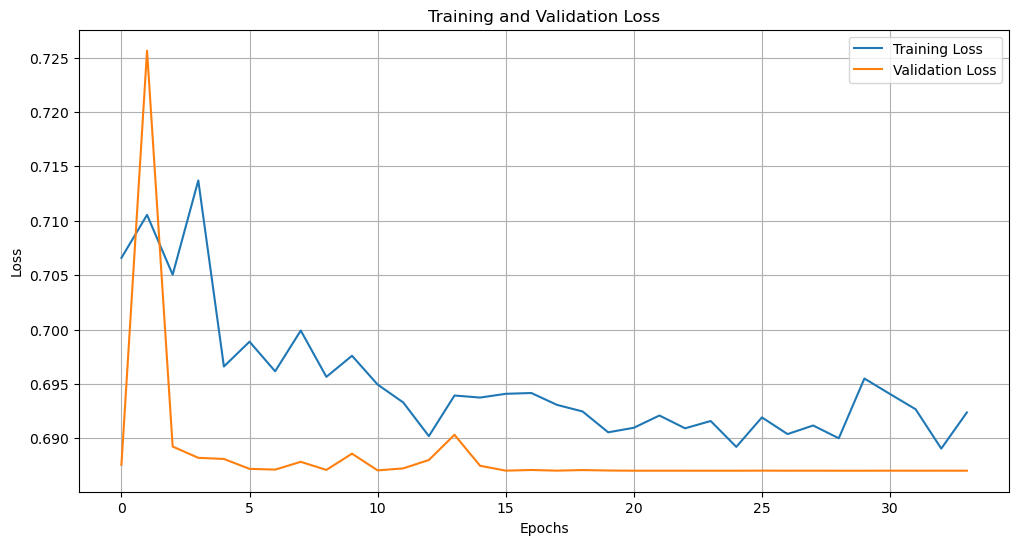

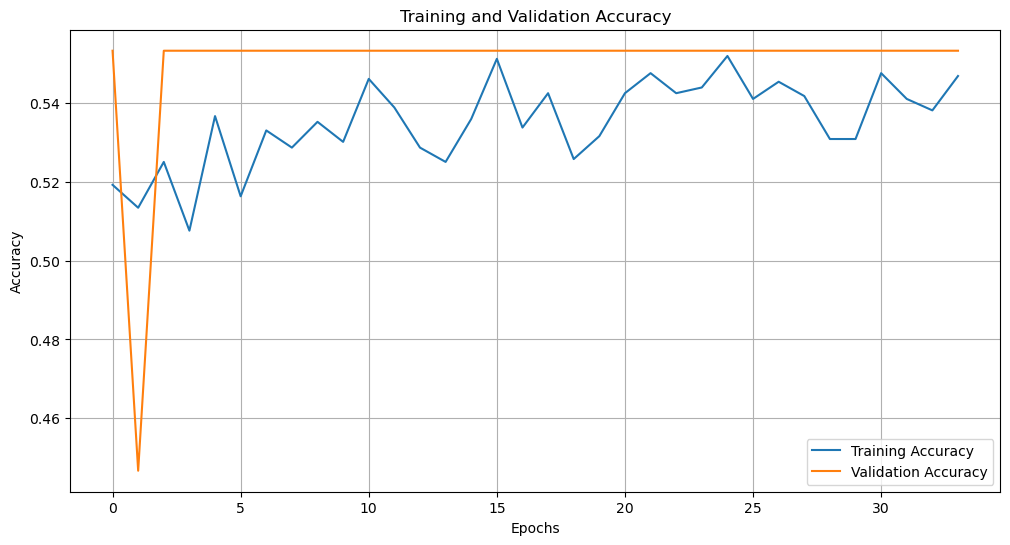

29/29 [==============================] - 4s 102ms/step
Classification Report:

              precision    recall  f1-score   support

  background       0.00      0.00      0.00       201
      packet       0.55      1.00      0.71       249

    accuracy                           0.55       450
   macro avg       0.28      0.50      0.36       450
weighted avg       0.31      0.55      0.39       450



/home/zboucek/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/zboucek/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/zboucek/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

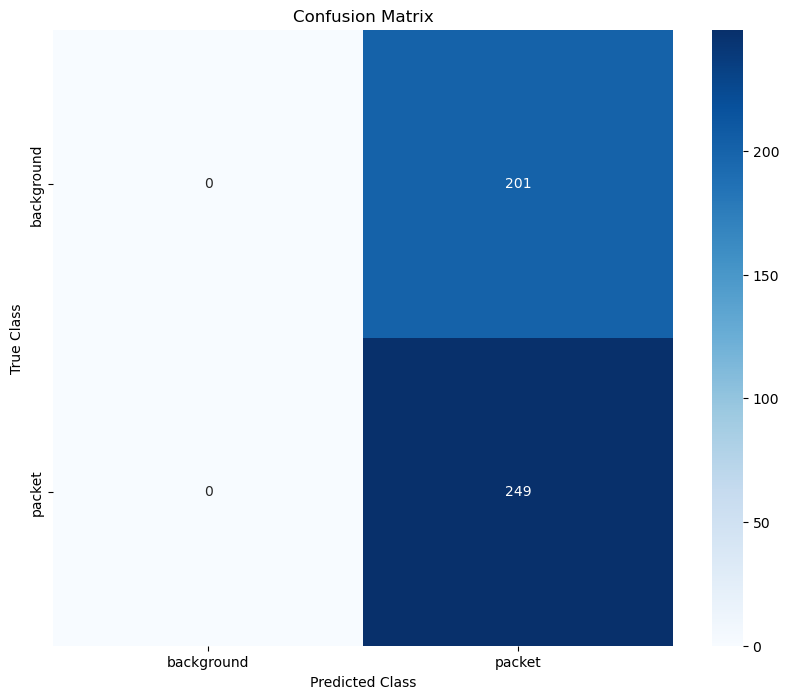

In [7]:
import matplotlib.pyplot as plt

# Retrieve history data
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs_range = range(len(train_loss))

# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, train_loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, train_accuracy, label="Training Accuracy")
plt.plot(epochs_range, val_accuracy, label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Predict on validation data
val_labels = val_generator.classes
val_predictions = model.predict(val_generator)
val_pred_classes = np.argmax(val_predictions, axis=1)

# Classification report
report = classification_report(val_labels, val_pred_classes, target_names=val_generator.class_indices.keys())
print("Classification Report:\n")
print(report)

# Confusion matrix
conf_matrix = confusion_matrix(val_labels, val_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

## TensorFlow Lite Conversion and Quantization

TensorFlow Lite (TFLite) is a lightweight version of TensorFlow that is designed for deploying machine learning models on mobile, edge, and IoT devices. In this section, we will:

1. Convert the trained Keras model to a TensorFlow Lite model.
2. Quantize the TensorFlow Lite model for reduced size and improved performance.

In [8]:
# Convert the trained Keras model to TensorFlow Lite format
tflite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tflite_converter.convert()

# Save the TFLite model
tflite_model_path = "model/classification.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

print(f"TensorFlow Lite model saved at: {tflite_model_path}")

INFO:tensorflow:Assets written to: /tmp/tmp77jzum57/assets


INFO:tensorflow:Assets written to: /tmp/tmp77jzum57/assets


TensorFlow Lite model saved at: model/classification.tflite


2025-01-13 13:08:44.516565: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2025-01-13 13:08:44.516609: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2025-01-13 13:08:44.527705: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp77jzum57
2025-01-13 13:08:44.548477: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-01-13 13:08:44.548498: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp77jzum57
2025-01-13 13:08:44.561031: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2025-01-13 13:08:44.601214: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2025-01-13 13:08:44.621722: I tensorflow/cc/save

In [9]:
# Define a representative dataset generator for quantization
def representative_data_gen():
    # Iterace přes validační dataset nebo jiný vhodný dataset
    dataset_list = tf.data.Dataset.list_files(DATASET_PATH + "/*/*/*")
    for i, image_path in enumerate(dataset_list.take(100)):  # Limitujeme na 100 vzorků
        image = tf.io.read_file(image_path)
        image = tf.io.decode_png(image, channels=args.image_channels)  # Přizpůsobení počtu kanálů
        image = tf.image.resize(image, [args.image_width, args.image_height])
        image = tf.cast(image, tf.float32) / 255.0  # Normalizace
        image = tf.expand_dims(image, 0)  # Přidání dimenze pro batch
        yield [image]

# Configure the converter for quantization
tflite_converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_converter.representative_dataset = representative_data_gen
tflite_converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
tflite_converter.target_spec.supported_types = [tf.int8]
tflite_converter.inference_input_type = tf.uint8
tflite_converter.inference_output_type = tf.uint8

# Convert and save the quantized TFLite model
try:
    quantized_model = tflite_converter.convert()
    quantized_model_path = f"{ROOT_PATH}/model/classification_q.tflite"
    with open(quantized_model_path, "wb") as f:
        f.write(quantized_model)
    print(f"Quantized TFLite model saved at {quantized_model_path}")
except Exception as e:
    print(f"Error during quantization: {e}")

INFO:tensorflow:Assets written to: /tmp/tmpgypwst8g/assets


INFO:tensorflow:Assets written to: /tmp/tmpgypwst8g/assets
/home/zboucek/anaconda3/envs/tf/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:947: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2025-01-13 13:09:00.099193: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2025-01-13 13:09:00.099212: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2025-01-13 13:09:00.099359: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpgypwst8g
2025-01-13 13:09:00.120379: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-01-13 13:09:00.120403: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpgypwst8g
2025-01-13 13:09:00.182013: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2025-01-13

Quantized TFLite model saved at /home/zboucek/mygit/cf/aideck-gap8-examples/examples/ai/classification/model/classification_q.tflite


fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


In [10]:
# Testing the model on validation data
batch_images, batch_labels = next(iter(val_generator))  # A single batch from the validation set
logits = model(batch_images)
prediction = np.argmax(logits, axis=1)
truth = np.argmax(batch_labels, axis=1)

keras_accuracy = tf.keras.metrics.Accuracy()
keras_accuracy.update_state(prediction, truth)
print(f"Raw Keras model accuracy: {keras_accuracy.result().numpy():.3%}")

# Helper function to set input tensor for the TFLite interpreter
def set_input_tensor(interpreter, input_image):
    input_details = interpreter.get_input_details()[0]
    tensor_index = input_details["index"]
    input_tensor = interpreter.tensor(tensor_index)()[0]
    input_tensor[:, :] = input_image

# Helper function to classify an image using the TFLite interpreter
def classify_image(interpreter, input_image):
    set_input_tensor(interpreter, input_image)
    interpreter.invoke()
    output_details = interpreter.get_output_details()[0]
    output = interpreter.get_tensor(output_details["index"])
    # Dequantize results
    scale, zero_point = output_details["quantization"]
    output = scale * (output - zero_point)
    return np.argmax(output)

# Perform inference using the quantized TFLite model
try:
    interpreter = tf.lite.Interpreter(model_path=quantized_model_path)
    interpreter.allocate_tensors()

    # Compare all predictions with ground truth
    tflite_accuracy = tf.keras.metrics.Accuracy()
    batch_prediction = []
    batch_truth = np.argmax(batch_labels, axis=1)

    for i in range(len(batch_images)):
        prediction = classify_image(interpreter, batch_images[i])
        batch_prediction.append(prediction)

    tflite_accuracy.update_state(batch_prediction, batch_truth)
    print(f"Quantized TFLite model accuracy: {tflite_accuracy.result().numpy():.3%}")
except Exception as e:
    print(f"Error testing quantized model: {e}")

Raw Keras model accuracy: 37.500%


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Quantized TFLite model accuracy: 62.500%
